# Data preparation and ingestion

In [155]:
# Imports
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
from elasticsearch import Elasticsearch
from statistics import median
from sentence_transformers import SentenceTransformer
import pickle
import matplotlib.pyplot as plt
import torch
import h5py

## Load the data

In [156]:
# Load in Pandas df
data_path = "../data/ancient_sources.csv.gz"
df = pd.read_csv(data_path, compression="gzip")
df.head()

,author,title,section,text
0,Aeschylus,Agamemnon,lines 1-39,Release from this weary task of mine has been ...
1,Euripides,Ion,lines 1-40,Before the Temple of Apollo at Delphi . The su...
2,Euripides,Heracles,lines 1-25,Before the palace of Heracles at Thebes . Near...
3,Euripides,Hippolytus,lines 1-33,Aphrodite enters above the skene. Aphrodite Ap...
4,Euripides,Heracleidae,lines 1-47,The skene represents the temple of Zeus Agorai...


In [157]:
# Check size
df.shape

(111709, 4)

## Data cleaning and EDA

In [158]:
# Append index as ID
df['Id'] = df.index

In [159]:
# Delete rows without text
df.drop(df[df["text"].isna()].index, inplace=True)

# Transform rows with NaN section to ""
df['section'] = df['section'].fillna("")

In [160]:
# Check new size
df.shape

(111707, 5)

In [161]:
# Create a function that counts number of words of a text
def count_words(text):
    return len(text.split())

# Append a column with the number of words of the texts
df["num_words"] = df["text"].apply(count_words)

# Show first rows
df.head()

,author,title,section,text,Id,num_words
0,Aeschylus,Agamemnon,lines 1-39,Release from this weary task of mine has been ...,0,445
1,Euripides,Ion,lines 1-40,Before the Temple of Apollo at Delphi . The su...,1,357
2,Euripides,Heracles,lines 1-25,Before the palace of Heracles at Thebes . Near...,2,279
3,Euripides,Hippolytus,lines 1-33,Aphrodite enters above the skene. Aphrodite Ap...,3,349
4,Euripides,Heracleidae,lines 1-47,The skene represents the temple of Zeus Agorai...,4,554


In [162]:
df["num_words"].describe()

count    111707.000000
mean        179.352252
std         367.455390
min           1.000000
25%          58.000000
50%          94.000000
75%         173.000000
max       31177.000000
Name: num_words, dtype: float64

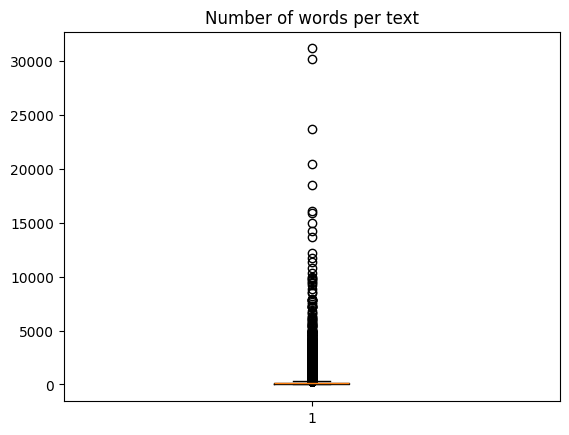

In [163]:
# Boxplot
boxplot_stats = plt.boxplot(df['num_words'])
plt.title('Number of words per text');

In [164]:
whiskers = [item.get_ydata() for item in boxplot_stats['whiskers']]
upp_whisker = whiskers[1][1]
print("Upper whisker:", upp_whisker)

Upper whisker: 345.0


In [165]:
df[df["num_words"] > 512].shape

(7786, 6)

The upper limit stablished by boxplot is 345 words, so let's cut all the texts with a number of words higher than 512 (a bit higher than the boxplot upper limit). With this change, more of the 90% of the text will remain with the full text. Hopefully, this will make the embbeding calculation ligther.

In [166]:
# Define function that truncates the longer texts
def truncate_texts(text, max_num_words=512):
    word_list = text.split()
    if len(word_list) > max_num_words:
        word_list = word_list[:max_num_words]

    return " ".join(word_list)

# Apply to all the texts
df["text"] = df["text"].apply(truncate_texts)

# Count again the num of words
df["num_words"] = df["text"].apply(count_words)

# Check df
df.head()

,author,title,section,text,Id,num_words
0,Aeschylus,Agamemnon,lines 1-39,Release from this weary task of mine has been ...,0,445
1,Euripides,Ion,lines 1-40,Before the Temple of Apollo at Delphi . The su...,1,357
2,Euripides,Heracles,lines 1-25,Before the palace of Heracles at Thebes . Near...,2,279
3,Euripides,Hippolytus,lines 1-33,Aphrodite enters above the skene. Aphrodite Ap...,3,349
4,Euripides,Heracleidae,lines 1-47,The skene represents the temple of Zeus Agorai...,4,512


In [167]:
# Check statistics again
df["num_words"].describe()

count    111707.000000
mean        148.231821
std         143.268450
min           1.000000
25%          58.000000
50%          94.000000
75%         173.000000
max         512.000000
Name: num_words, dtype: float64

In [168]:
# Drop number of words column
df.drop('num_words', axis=1, inplace=True)

## Generate text embeddings for vector search

We are going to use *msmarco-roberta-base-ance-firstp* model, which is well suited for long passages of text and is fine-tunned for dot product similarity, which is usually preferred for long passages of text (our case). Also, it is optimized for ANCE (Approximate Nearest Neighbor Search). Later, we will have to take all this into account by configuring Elasticsearch k-NN to use dot product and Approximate Nearest Neighbor Search.

In [169]:
# Transform into a list of dicts
df_dict = df.to_dict(orient="records")

# Generate list with all the texts
texts_list = [source["text"]for source in df_dict]

In [180]:
# Load the msmarco-roberta-base-ance-firstp
model = SentenceTransformer('msmarco-roberta-base-ance-firstp')

# Load it for GPU exec
# model = SentenceTransformer('msmarco-roberta-base-ance-firstp', device='cuda')

/usr/local/python/3.12.1/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [20]:
# Check for GPU availability
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Device Count: {torch.cuda.device_count()}")
print(f"Current Device: {torch.cuda.current_device()}")
print(f"Device Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

CUDA Available: True
Device Count: 1
Current Device: 0
Device Name: Tesla T4


In [21]:
# Compute embeddings
embeddings = model.encode(texts_list, batch_size=32, show_progress_bar=True)

Batches:   0%|          | 0/3491 [00:00<?, ?it/s]

In [ ]:
# Save embeddings
with h5py.File('../data/embeddings.h5', 'w') as hf:
    hf.create_dataset('embeddings', data=embeddings, compression='gzip', compression_opts=9)

In [170]:
# Load embeddings
with h5py.File('../data/embeddings.h5', 'r') as hf:
    dataset = hf['embeddings']
    
    # Load the data into a NumPy array
    embeddings = dataset[:]

In [171]:
# Show dims
embeddings.shape

(111707, 768)

In [172]:
# The vectors have to be normalized in order to use dot product similarity in elasticsearch
def normalize_vector(vector):
    norm = np.linalg.norm(vector)
    if norm == 0:
        return vector  # Avoid division by zero
    return vector / norm

normalized_embeddings = np.apply_along_axis(normalize_vector, 1, embeddings)

In [173]:
normalized_embeddings.shape

(111707, 768)

In [174]:
# Append embeddings to the corresponding sources
for i, source in enumerate(df_dict):
    source["text_embedding"] = normalized_embeddings[i]

## Generate title embeddings with OpenAI

In [120]:
# Login keys
load_dotenv()

# To interact with OpenAI
client = OpenAI()

In [121]:
# Function that obtains the embeddings of a list of titles
def get_embeddings(texts, model="text-embedding-3-small", dimensions=256):
    # Ensure texts are in a list and each text is cleaned
    cleaned_texts = [text.replace("\n", " ") for text in texts]

    # Call the OpenAI API to generate embeddings for all texts
    response = client.embeddings.create(
        input=cleaned_texts, 
        model=model,
        dimensions=dimensions
    )

    # Extract embeddings from the response
    embeddings = [item.embedding for item in response.data]

    # Return as numpy array
    return np.array(embeddings)

In [122]:
# Obtain all the list of titles
titles_list = [source["title"] for source in df_dict]

In [126]:
# Generate batches
batch_size = 500
batches = [titles_list[i:i + batch_size] for i in range(0, len(titles_list), batch_size)]

In [132]:
# Compute embeddings in batch mode
title_embeddings = []

for i, batch in enumerate(tqdm(batches)):
    try:
        title_embeddings.append(get_embeddings(batch))
    except Exception as e:
        print(f"Failed to generate embeddings for batch: {i}. Error: {str(e)}")

  0%|          | 0/224 [00:00<?, ?it/s]

In [137]:
title_embeddings_def = []

for batch in title_embeddings:
    for emb in batch:
        title_embeddings_def.append(emb)

In [142]:
title_embeddings_array = np.array(title_embeddings_def)

In [144]:
title_embeddings_array.shape

(111707, 256)

In [145]:
# Save title embeddings
with h5py.File('../data/title_embeddings.h5', 'w') as hf:
    hf.create_dataset('title_embeddings', data=title_embeddings_array, compression='gzip', compression_opts=9)

In [ ]:
# Load title embeddings
with h5py.File('../data/title_embeddings.h5', 'r') as hf:
    dataset = hf['title_embeddings']
    
    # Load the data into a NumPy array
    title_embeddings_array = dataset[:]

In [151]:
# Append embeddings to the corresponding sources
for i, source in enumerate(df_dict):
    source["title_embedding"] = title_embeddings_array[i]

## Indexing with Elasticsearch

In [175]:
es_client = Elasticsearch("http://localhost:9200")

In [176]:
es_client.info()

ObjectApiResponse({'name': 'a990a1e2e254', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'AfI-EwkTQRS7S0r8-lovww', 'version': {'number': '8.15.0', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '1a77947f34deddb41af25e6f0ddb8e830159c179', 'build_date': '2024-08-05T10:05:34.233336849Z', 'build_snapshot': False, 'lucene_version': '9.11.1', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [177]:
# Create Elasticsearch index
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "author": {"type": "text"},
            "title": {"type": "text"},
            "text": {"type": "text"},
            "section": {"type": "keyword"},
            "id": {"type": "keyword"},
            "text_embedding": {
                "type": "dense_vector",
                "dims": 768,
                "element_type": "float",
                "index": True,
                "similarity": "dot_product",
                "index_options": {
                    "type": "int8_hnsw"
                }
            }
        }
    }
}

index_name = "ancient_sources_db_index"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'ancient_sources_db_index'})

In [179]:
# Index all the ancient sources
for src in tqdm(df_dict):
    es_client.index(index=index_name, document=src)

  0%|          | 0/111707 [00:00<?, ?it/s]

In [181]:
# Test question
question = "Could you give me the Hannibal description?"

q_embedding = model.encode(question)
q_emb_normalized = normalize_vector(q_embedding)

In [182]:
# Vector search query
knn_query = {
    "field": "text_embedding",
    "query_vector": q_emb_normalized,
    "k": 5,
    "num_candidates": 1000,
    "boost": 1,
}

In [183]:
# Semantic search query
keyword_query = {
    "bool": {
        "must": {
            "multi_match": {
                "query": question,
                "fields": ["author", "title^2", "text"],
                "type": "best_fields",
                "boost": 1,
            }
        }
    }
}

In [184]:
index_name = "ancient_sources_db_index"

response = es_client.search(
    index=index_name,
    query=keyword_query,
    knn=knn_query,
    size=5,
    _source={
        "excludes": ["text_embedding"]  # Exclude the embedding vectors of the response
    }
)

In [185]:
for answer in response["hits"]["hits"]:
    print(f"Author: {answer["_source"]["author"]}\nTitle: {answer["_source"]["title"]}\nSection: {answer["_source"]["section"]}\nText: {answer["_source"]["text"]}\n")

Author: Demosthenes
Title: On the Crown
Section: On the Crown, section 250
Text: [ 250 ] When, on my impeachment, you acquitted me, and did not give the prosecutors the fifth part of your votes, your verdict implied approval of my policy. When I was indicted, I satisfied you that my proposals and my speeches had been constitutional. When you put the seal on my accounts, you further admitted that I had done my business honestly and without corruption. That being so, what description could Ctesiphon properly and honestly have applied to my conduct, other than that which he had seen applied by the whole nation and by sworn juries, and confirmed by the truth in the eyes of all men?

Author: Plato
Title: Euthydemus
Section: Euthydemus, section 286a
Text: [ 286a ] as each is, or as it is not? As it is. Yes, he said, for if you recollect, Ctesippus, we showed just now that no one speaks of a thing as it is not; since we saw that no one speaks what is not. Well, what of that? asked Ctesippus: 